In [1]:
# In QuTiP (updated for Model B)
from qutip import *
import numpy as np

# System parameters (same as before)
N = 3
qubit_c = 1  # Target qubit (0, 1, 2)
w_q = 5.0 * 2 * np.pi  # Qubit frequency in GHz
Omega_c = 10.0 * 2 * np.pi  # Rabi frequency (e.g., for a 25 ns gate)
J_coupling = 0.1 * Omega_c  # Coupling strength, e.g., 10% of Omega_c

# Pauli operators (same as before)
sm = [tensor([qeye(2)]*i + [sigmam()] + [qeye(2)]*(N-1-i)) for i in range(N)]
sx = [tensor([qeye(2)]*i + [sigmax()] + [qeye(2)]*(N-1-i)) for i in range(N)]
sz = [tensor([qeye(2)]*i + [sigmaz()] + [qeye(2)]*(N-1-i)) for i in range(N)]

# Pulse shape (same)
def pulse_shape(t, args):
    return np.exp(-(t - args['t0'])**2 / (2 * args['tau']**2))

# 1. Drift Hamiltonian (unchanged)
H_drift = -0.5 * w_q * sz[0] - 0.5 * w_q * sz[1] - 0.5 * w_q * sz[2]

# 2. Control Hamiltonian operator (unchanged)
H_control_op = Omega_c * sx[qubit_c]

# 3. Crosstalk Hamiltonian operator (NEW: Model B with induced coupling)
# Note: sx[c-1] * sx[c] is the tensor product for the bilinear term
H_crosstalk_op = J_coupling * (sx[qubit_c-1] * sx[qubit_c] + sx[qubit_c] * sx[qubit_c+1])

# Combine into time-dependent Hamiltonian (unchanged format)
H = [H_drift, [H_control_op + H_crosstalk_op, pulse_shape]]

# Collapse operators for Lindblad (unchanged)
T1 = 50000  # 50 us
T2_star = 10000  # 10 us
gamma1 = 1.0 / T1
gamma2_star = 1.0 / T2_star
c_ops = []
for i in range(N):
    c_ops.append(np.sqrt(gamma1) * sm[i])  # T1 decay
    c_ops.append(np.sqrt(gamma2_star) * sz[i])  # T2* dephasing

# Initial state and simulation (unchanged)
psi0 = tensor(basis(2,0), basis(2,0), basis(2,0))
tlist = np.linspace(0, 100, 201)  # Simulate for 100 ns
args = {'t0': 50, 'tau': 15}
result = mesolve(H, psi0, tlist, c_ops, 
                 e_ops=[sz[0], sz[1], sz[2]],  # Track <sigma_z> for each qubit
                 args=args)


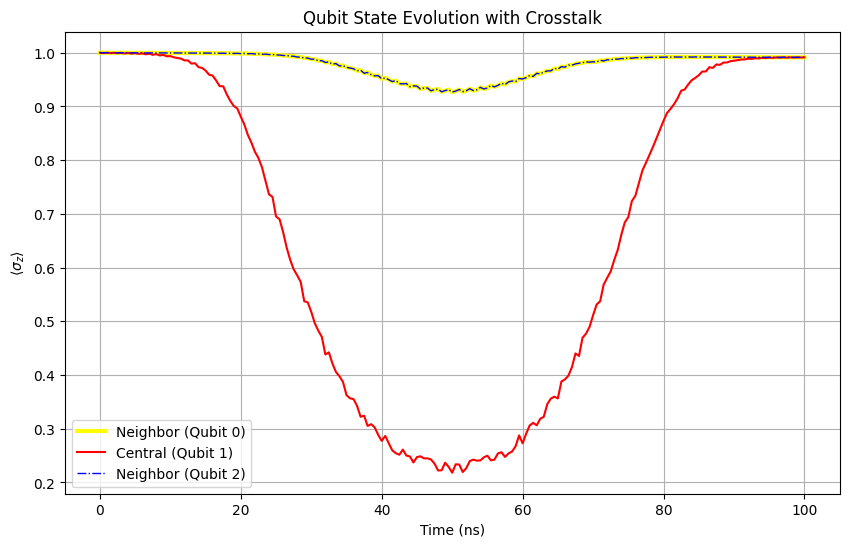

In [37]:
import matplotlib.pyplot as plt

# Extract data
times = result.times  # This is your tlist
exp_sz0 = result.expect[0]  # <sigma_z> for qubit 0 (neighbor)
exp_sz1 = result.expect[1]  # <sigma_z> for qubit 1 (central)
exp_sz2 = result.expect[2]  # <sigma_z> for qubit 2 (neighbor)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(times, exp_sz0, label='Neighbor (Qubit 0)', color='yellow', linestyle='-', linewidth=3)
plt.plot(times, exp_sz1, label='Central (Qubit 1)', color='red')
plt.plot(times, exp_sz2, label='Neighbor (Qubit 2)', color='blue', linestyle='-.', linewidth=1)
plt.xlabel('Time (ns)')
plt.ylabel(r'$\langle \sigma_z \rangle$')
plt.title('Qubit State Evolution with Crosstalk')
plt.legend()
plt.grid(True)
plt.show()


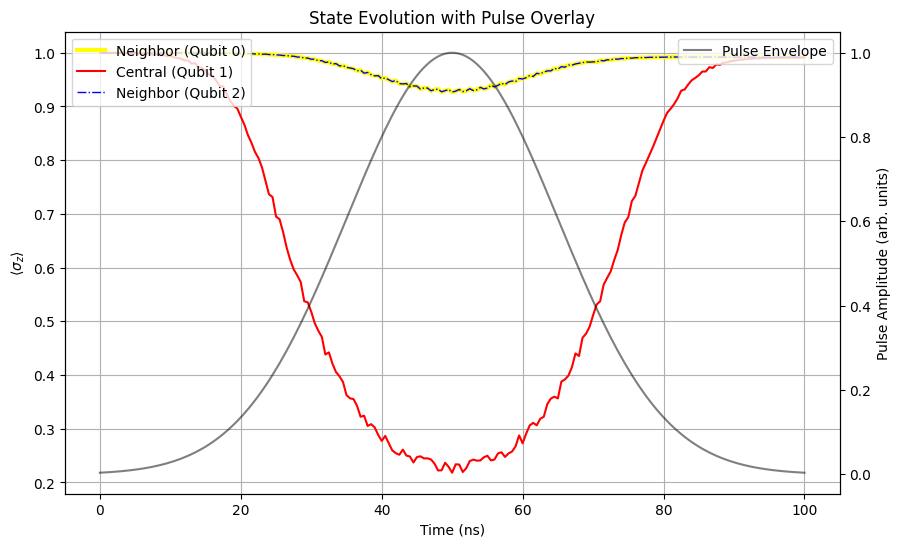

In [35]:
# Define the pulse shape function (from your simulation)
def pulse_shape(t, args):
    return np.exp(-(t - args['t0'])**2 / (2 * args['tau']**2))

# Compute pulse values
pulse_vals = [pulse_shape(t, args) for t in times]  # args = {'t0': 50, 'tau': 15}

# Updated plot with pulse overlay (twin axis for different scales)
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(times, exp_sz0, label='Neighbor (Qubit 0)', color='yellow', linestyle='-', linewidth=3)
ax1.plot(times, exp_sz1, label='Central (Qubit 1)', color='red')
ax1.plot(times, exp_sz2, label='Neighbor (Qubit 2)', color='blue', linestyle='-.', linewidth = 1)
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel(r'$\langle \sigma_z \rangle$')
ax1.legend(loc='upper left')
ax1.grid(True)

ax2 = ax1.twinx()  # Secondary axis for pulse
ax2.plot(times, pulse_vals, label='Pulse Envelope', color='black', alpha=0.5)
ax2.set_ylabel('Pulse Amplitude (arb. units)')
ax2.legend(loc='upper right')

plt.title('State Evolution with Pulse Overlay')
plt.show()


In [6]:
# Run mesolve without e_ops to get full states, or add to existing
result_full = mesolve(H, psi0, tlist, c_ops, args=args)  # Returns result.states as list of density matrices


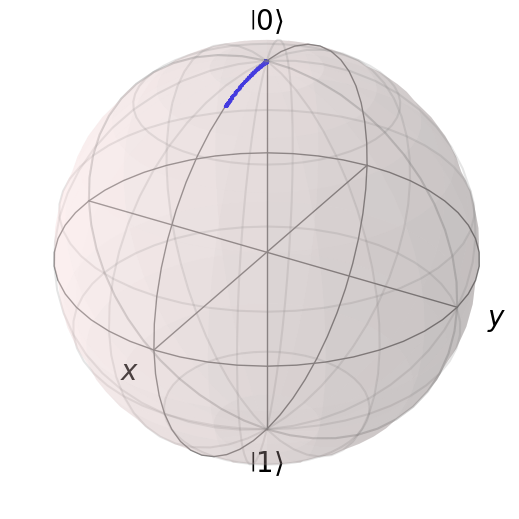

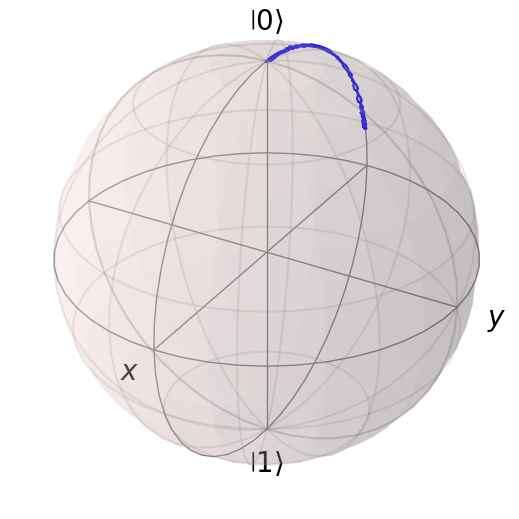

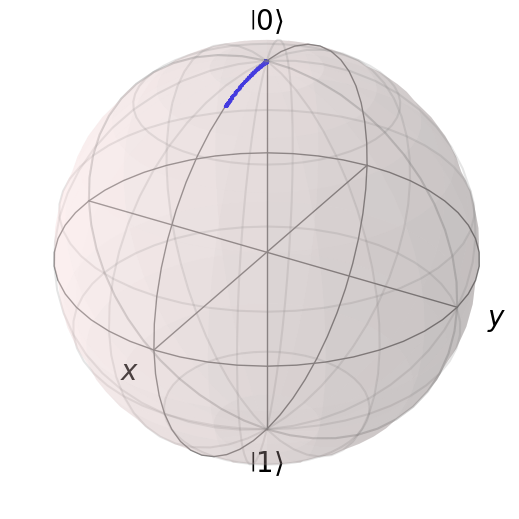

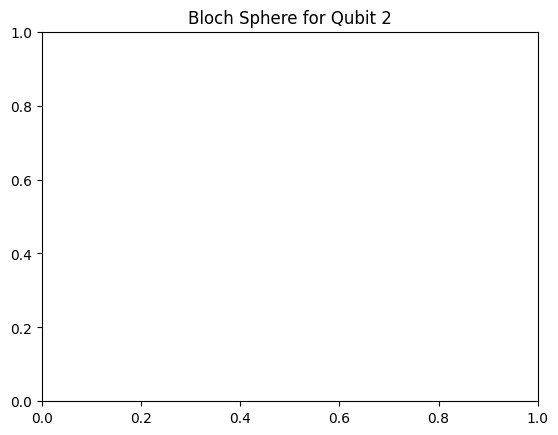

In [7]:
from qutip import Bloch

# Function to get Bloch vector for a single qubit (by partial trace)
def get_bloch_vector(rho, qubit_index, N):
    # Partial trace over all but the target qubit
    rho_qubit = rho.ptrace(qubit_index)
    # Bloch vector components: <sx>, <sy>, <sz>
    sx_exp = expect(sigmax(), rho_qubit)
    sy_exp = expect(sigmay(), rho_qubit)
    sz_exp = expect(sigmaz(), rho_qubit)
    return [sx_exp, sy_exp, sz_exp]

# Create Bloch spheres for each qubit
bspheres = [Bloch() for _ in range(N)]
colors = ['blue', 'red', 'green']

for i in range(N):
    bspheres[i].add_points([[get_bloch_vector(rho, i, N)[j] for rho in result_full.states] for j in range(3)], meth='l')  # 'l' for line
    bspheres[i].make_sphere()

# Display (you can subplot them if desired)
for i, b in enumerate(bspheres):
    b.show()
    plt.title(f'Bloch Sphere for Qubit {i}')


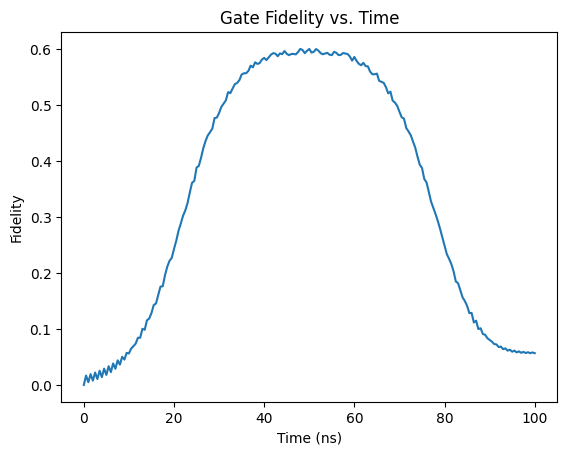

In [9]:
# Ideal final state: qubits 0 and 2 in |0>, central in |1>
ideal_psi = tensor(basis(2,0), basis(2,1), basis(2,0))
ideal_rho = ket2dm(ideal_psi)

# Fidelity over time
fidelities = [fidelity(rho, ideal_rho) for rho in result_full.states]

plt.plot(times, fidelities)
plt.xlabel('Time (ns)')
plt.ylabel('Fidelity')
plt.title('Gate Fidelity vs. Time')
plt.show()


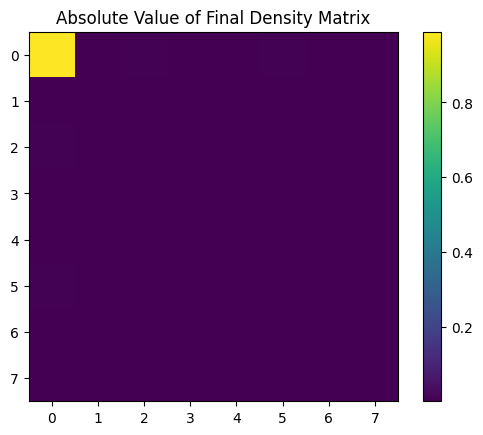

In [10]:
final_rho = result_full.states[-1]
plt.imshow(np.abs(final_rho.full()), cmap='viridis')
plt.colorbar()
plt.title('Absolute Value of Final Density Matrix')
plt.show()


In [ ]:
pip install qutip matplotlib numpy pillow


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
